In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from keras.layers import Dropout
from tensorflow.keras.applications import resnet
import matplotlib.pyplot as plt
import time

target_shape = (40,)

In [ ]:
# load anchor_samples array from npy file
from numpy import load
# load array
anchor_samples = load('/content/drive/MyDrive/Colab Notebooks/thesis_code_main/feature_extracted_saved_arrays/train/anchor.npy')
# print the array
# print(anchor_samples)
# print(np.transpose(anchor_samples)[0].shape)
# print(anchor_samples[0].shape)
# print(anchor_samples.shape)

# anchor_tensor = tf.convert_to_tensor(anchor_samples)
# print(type(anchor_tensor))
anchor_tensor = tf.data.Dataset.from_tensors(anchor_samples)


In [ ]:
# load positive_samples array from npy file
from numpy import load
# load array

positive_samples = load('/content/drive/MyDrive/Colab Notebooks/thesis_code_main/feature_extracted_saved_arrays/train/positive.npy')
# print the array
# print(positive_samples)

# positive_tensor = tf.convert_to_tensor(positive_samples)

positive_tensor = tf.data.Dataset.from_tensors(positive_samples)

In [ ]:
# load negative_samples array from npy file
from numpy import load
# load array
negative_samples = load('/content/drive/MyDrive/Colab Notebooks/thesis_code_main/feature_extracted_saved_arrays/train/negative.npy')
# print the array
# print(negative_samples)

# negative_tensor = tf.convert_to_tensor(negative_samples)

negative_tensor = tf.data.Dataset.from_tensors(negative_samples)

In [ ]:
# load speaker_id array from npy file
from numpy import load
# load array
speaker_id = load('/content/drive/MyDrive/Colab Notebooks/thesis_code_main/feature_extracted_saved_arrays/train/speaker_id.npy')
# print the array
# print(speaker_id)

In [ ]:
input_layer = tf.keras.Input(shape=(40,))
dense1 = layers.Dense(80, activation='relu')(input_layer)
dense1 = layers.BatchNormalization()(dense1)
dense1 = Dropout(0.1)(dense1)
dense2 = layers.Dense(40, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
dense2 = Dropout(0.1)(dense2)
output = layers.Dense(40)(dense2)


embedding = Model(input_layer, output, name="Embedding")
print(embedding.summary())

Model: "Embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
dense (Dense)                (None, 80)                3280      
_________________________________________________________________
batch_normalization (BatchNo (None, 80)                320       
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                3240      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40)                160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0 

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)



anchor_input = layers.Input(name="anchor", shape=target_shape)
positive_input = layers.Input(name="positive", shape=target_shape)
negative_input = layers.Input(name="negative", shape=target_shape)

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input)
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)


In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [ ]:
row_count = len(anchor_tensor)
dataset = tf.data.Dataset.zip((anchor_tensor, positive_tensor, negative_tensor))
train_dataset = dataset.take(round(row_count * 0.8))
val_dataset = dataset.skip(round(row_count * 0.8))


# **TRAINING**

In [ ]:
start_time = time.time()
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.001))
history = siamese_model.fit(train_dataset, epochs=20, validation_data=val_dataset)
end_time = time.time()
print("Total execution time: ", end_time-start_time)

Epoch 1/20
1/1 [==============================] - 1s 882ms/step - loss: 0.9431
Epoch 2/20
1/1 [==============================] - 0s 72ms/step - loss: 0.9051
Epoch 3/20
1/1 [==============================] - 0s 71ms/step - loss: 0.7875
Epoch 4/20
1/1 [==============================] - 0s 71ms/step - loss: 0.7354
Epoch 5/20
1/1 [==============================] - 0s 72ms/step - loss: 0.6735
Epoch 6/20
1/1 [==============================] - 0s 77ms/step - loss: 0.6215
Epoch 7/20
1/1 [==============================] - 0s 70ms/step - loss: 0.5794
Epoch 8/20
1/1 [==============================] - 0s 69ms/step - loss: 0.5373
Epoch 9/20
1/1 [==============================] - 0s 68ms/step - loss: 0.4967
Epoch 10/20
1/1 [==============================] - 0s 70ms/step - loss: 0.4634
Epoch 11/20
1/1 [==============================] - 0s 71ms/step - loss: 0.4342
Epoch 12/20
1/1 [==============================] - 0s 72ms/step - loss: 0.4054
Epoch 13/20
1/1 [==============================] - 0s 75ms/s

# **VALIDATION**

In [ ]:
sample = next(iter(train_dataset))

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(anchor),
    embedding(positive),
    embedding(negative),
)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())


negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.97060883
Negative similarity 0.91290116



# **LOADING SUPPORT AND QUERY SET**

In [ ]:
# from sklearn.preprocessing import RobustScaler

# def scale(array):
#     scaler = RobustScaler()
#     scaler.fit(array)

#     features_Standard_scaled = scaler.transform(array)

#     return features_Standard_scaled

In [ ]:
from numpy import load

base_path = '/content/drive/MyDrive/Colab Notebooks/thesis_code_main/feature_extracted_saved_arrays/test/'

support_set_5 = load(base_path + 'support_set_5.npy')
support_set_speaker_id_5 = load(base_path + 'support_set_speaker_id_5.npy')

query_set_5 = load(base_path + 'query_set_5.npy')
query_set_speaker_id_5 = load(base_path + 'query_set_speaker_id_5.npy')


# Converting the arrays into tensors
support_set_5_tensor = tf.data.Dataset.from_tensors(support_set_5)
support_set_speaker_id_5_tensor = tf.data.Dataset.from_tensors(support_set_speaker_id_5)

query_set_5_tensor = tf.data.Dataset.from_tensors(query_set_5)
query_set_speaker_id_5_tensor = tf.data.Dataset.from_tensors(query_set_speaker_id_5)

# **TESTING**

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

support_embedding, query_embedding = (
        embedding(tf.data.experimental.get_single_element(support_set_5_tensor)),
        embedding(tf.data.experimental.get_single_element(query_set_5_tensor))
        )

In [ ]:
predicted_id = []
q_index = 0
accuracy_count = 0

while q_index < len(query_set_5):

    s_index = 0
    maximum = -1
    index_maximum = -1

    while s_index < len(support_set_5):

        similarity = cosine_similarity(support_embedding[s_index], query_embedding[q_index]).numpy()
        if(similarity > maximum):
            maximum = similarity
            index_maximum = s_index
        s_index += 1

    predicted_id.append(support_set_speaker_id_5[index_maximum])
    q_index += 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(query_set_speaker_id_5, predicted_id))

              precision    recall  f1-score   support

        1188       0.62      0.20      0.30        25
        1284       0.95      0.80      0.87        25
        1580       0.90      0.36      0.51        25
         237       0.54      1.00      0.70        25
          61       0.55      0.88      0.68        25

    accuracy                           0.65       125
   macro avg       0.71      0.65      0.61       125
weighted avg       0.71      0.65      0.61       125



In [ ]:
print(confusion_matrix(query_set_speaker_id_5, predicted_id))

[[19  0  0  1  5]
 [ 0 17  0  8  0]
 [ 0  1 19  4  1]
 [ 0  0  0 25  0]
 [12  0  0  0 13]]


In [ ]:
# siamese_model.metrics_names
# siamese_model.metrics['loss']

In [ ]:
# # plt.plot(history.history['loss'])
# plt.plot(siamese_model.get_losses_for['loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

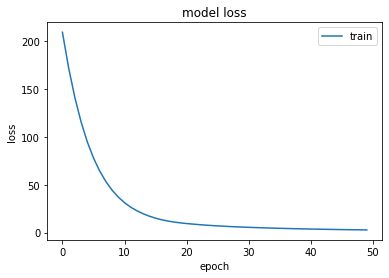

In [ ]:
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
import os,psutil
pid = os.getpid()
print(pid)
ps = psutil.Process(pid)
memoryUse = ps.memory_info()
print(memoryUse)

75
pmem(rss=1205026816, vms=43439161344, shared=460562432, text=4620288, lib=0, data=1261850624, dirty=0)


In [ ]:
def keras_model_memory_usage_in_bytes(model, *, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

In [ ]:
# memory = keras_model_memory_usage_in_bytes (siamese_model, batch_size= 32 )
# print ("Total memory used: ", memory)

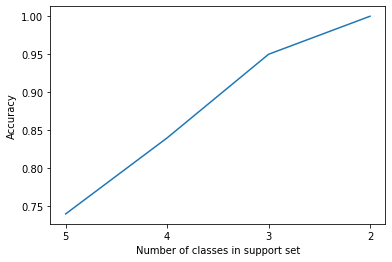

In [ ]:
x = ['5','4','3','2']
y = [0.74,0.84,0.95,1.0]
plt.plot(x,y)
plt.xlabel('Number of classes in support set')
plt.ylabel('Accuracy')
plt.show()

[[22  2  3  0]
 [ 0 21  3  0]
 [ 0  0 19  3]
 [ 3  2  0 22]]


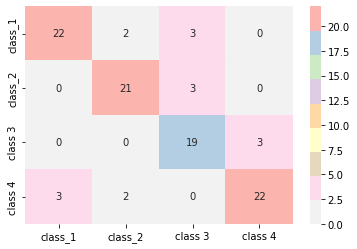

In [ ]:
#4 class
from sklearn.metrics import confusion_matrix
matrix=confusion_matrix(predicted_id, query_set_speaker_id_5 )
print(matrix)
from seaborn import heatmap
heatmap(matrix , cmap="Pastel1_r", xticklabels=['class_1' ,'class_2', 'class 3', 'class 4'], yticklabels=['class_1', 'class_2', 'class 3', 'class 4'], annot=True)

[[19  0  0  0 12]
 [ 0 17  1  0  0]
 [ 0  0 19  0  0]
 [ 1  8  4 25  0]
 [ 5  0  1  0 13]]


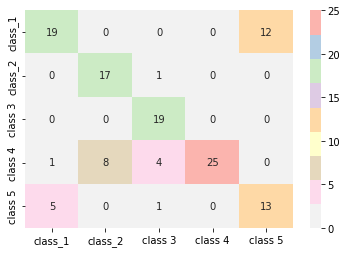

In [ ]:
#5 class
from sklearn.metrics import confusion_matrix
matrix=confusion_matrix(predicted_id, query_set_speaker_id_5 )
print(matrix)
from seaborn import heatmap
heatmap(matrix , cmap="Pastel1_r", xticklabels=['class_1' ,'class_2', 'class 3', 'class 4', 'class 5'], yticklabels=['class_1', 'class_2', 'class 3', 'class 4', 'class 5'], annot=True)